## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [27]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt

%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()
test_data = pd.read_csv('./Test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [2]:
#take a look at our data:
#does it have any null values?
train_data.isnull().values.any()

False

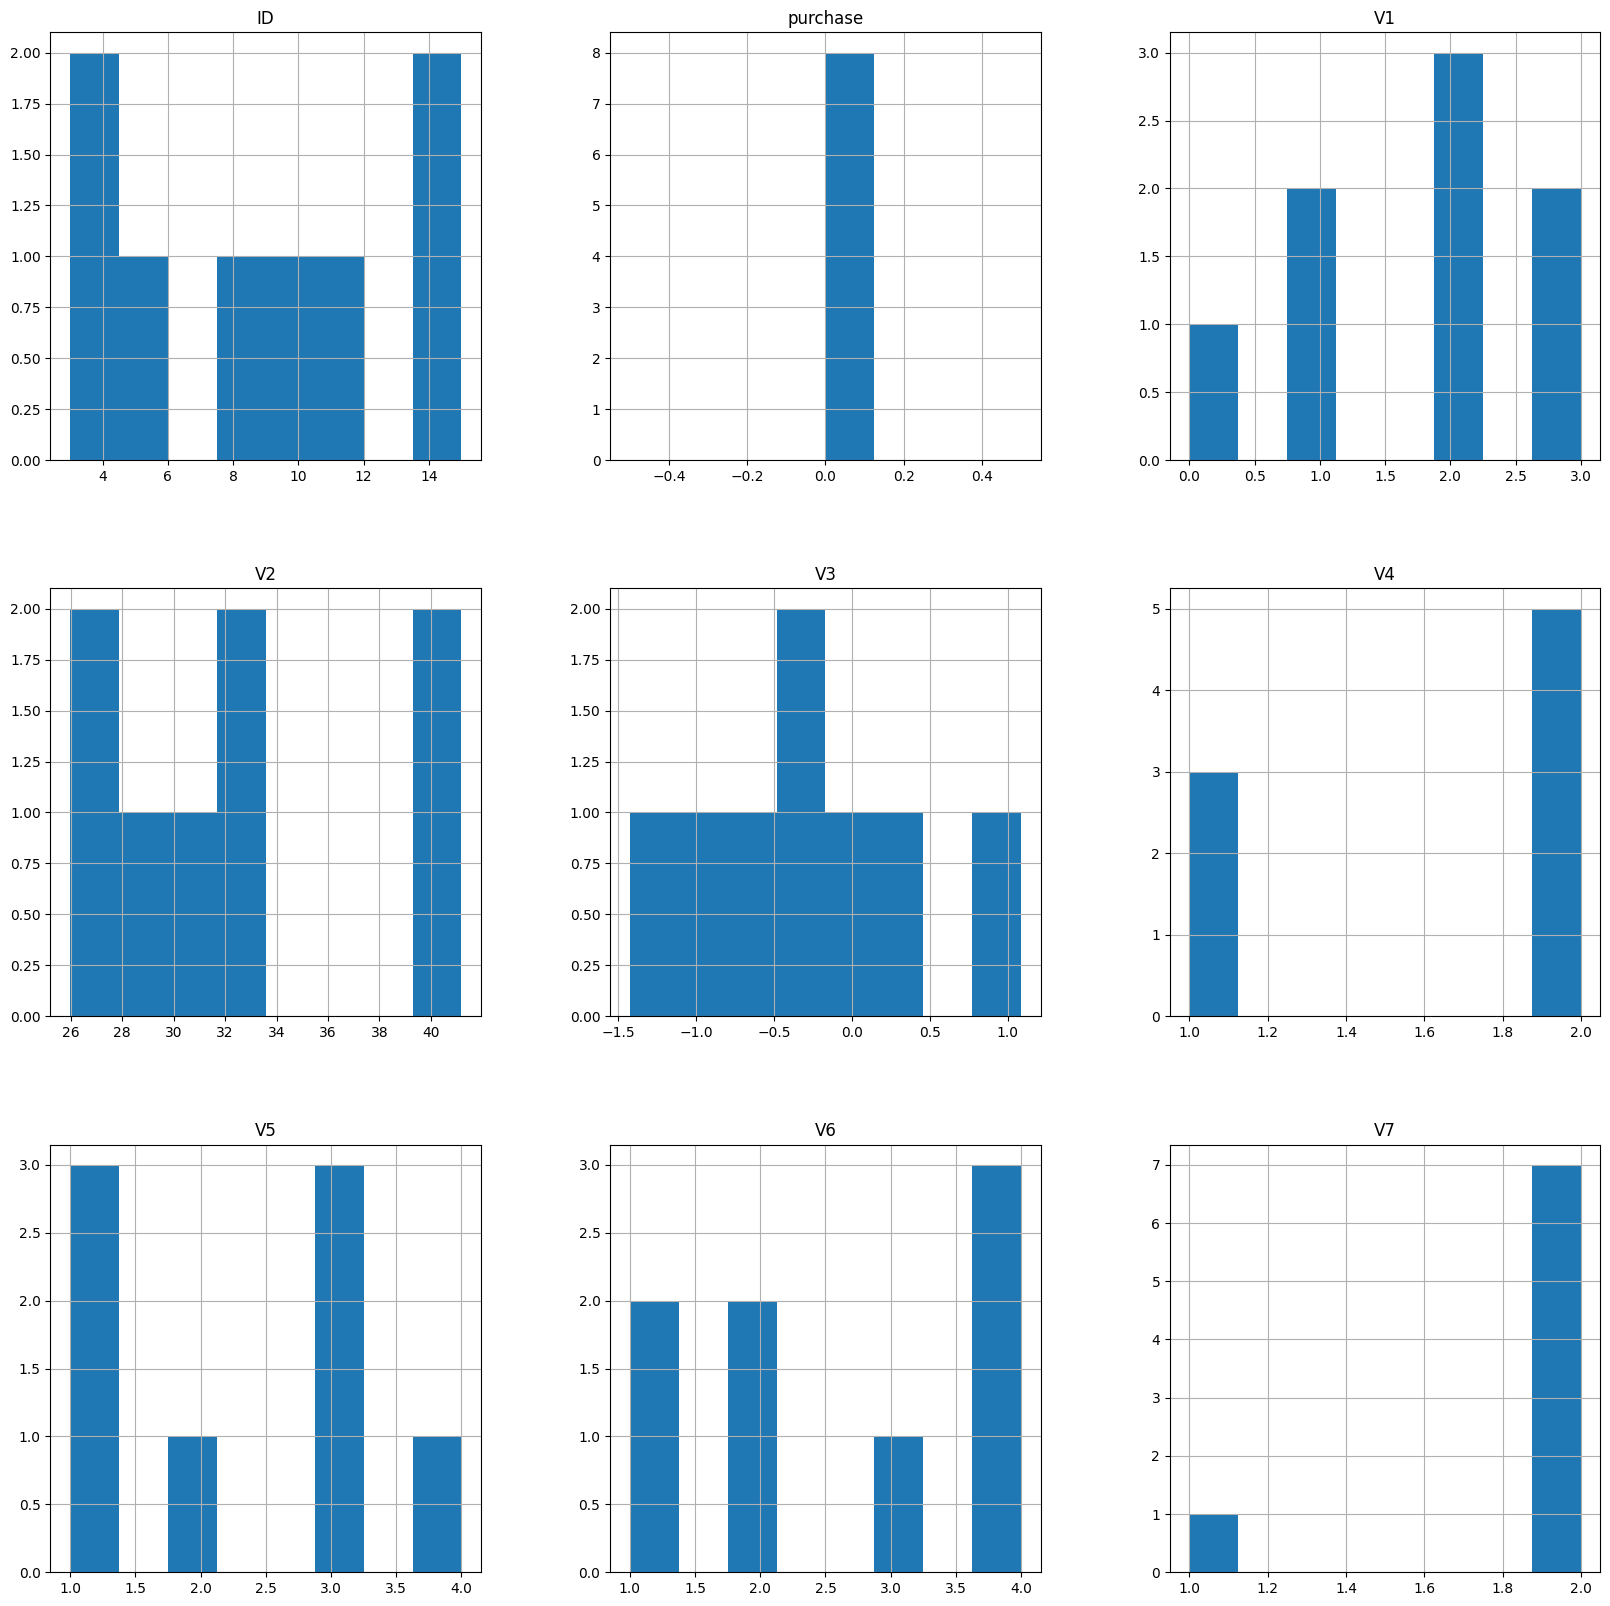

In [9]:
#Lets look at how our data distribution looks like for each of the variables of interest
train_hist = train_data[1:9].hist(bins=8, figsize=(20,20))

<Axes: >

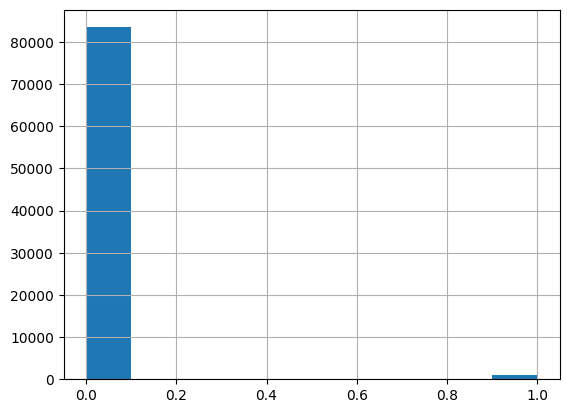

In [4]:
#none of the data is currently normally distributed.. We also seem to have a very little purchases overall for the experiment
train_data['purchase'].hist()

In [7]:
train_data['purchase'].value_counts()

purchase
0    83494
1     1040
Name: count, dtype: int64

In [23]:
#the ratio of purchases is fairly small, for our promotions offered, this should be equally distributed between the control and the experiment
promotion = train_data['Promotion'].value_counts()
print(promotion)

Promotion
Yes    42364
No     42170
Name: count, dtype: int64


In [19]:
#let's take a look at our training data and see out of those who were offered a promotion, how many actually purchased:
offered_promotion = train_data[train_data['Promotion']=='Yes'].purchase.value_counts()
no_promotion_offered = train_data[train_data['Promotion'] == 'No'].purchase.value_counts()
print(offered_promotion)

purchase
0    41643
1      721
Name: count, dtype: int64


## Optimization Strategy
Let's take a look at the data for our training data to see how the NIR, and IRR resulted

In [26]:
#Offered promotion and purchased
purchased_treatment = offered_promotion[1]
#no promotion offered and purchased
purchased_control = no_promotion_offered[1]
treatment_total = promotion[0]
control_total = promotion[1]
#calcultate irr:
irr = (purchased_treatment / treatment_total) - (purchased_control/control_total)
#calculate nir:
nir = (10 * purchased_treatment) - (0.15 * treatment_total) - (10 * purchased_control)

print(f'Incremental Response Rate is: {irr}')
print(f'Net Incremental Value: {nir}')

Incremental Response Rate is: 0.009454547819772702
Net Incremental Value: -2334.5999999999995


In [29]:
#ratio for purchases for entire experiment
print((purchased_control + purchased_treatment)/(treatment_total+control_total))
#this number is fairly low, so we will have to upsample the our data accordingly 

0.012302742091939338


Our optimization strategy requires us to maximize NIR and IRR. In order to do so, we must focus on maximizing the amounts of purchases made 
from the treatment side (meaning those offered the promotion). If a customer made a purchase on control side we will actually lower our IRR value and NIR value. 
To do so, we should separate the data in a way where the purchases made with a promotion are assigned a specific column and the purchases made on the control are not part
of the metrics we want to look for. 

In [31]:
#create a new column called "target" to get the promotional purchases to be "on"
train_data["Target"] = np.where((train_data['Promotion']=='Yes') &  (train_data['purchase']==1), 1, 0)

In [32]:
train_data.tail()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,Target
84529,126180,No,0,1,30.084876,1.345672,1,1,3,1,0
84530,126181,Yes,0,3,33.501485,-0.299306,1,1,4,1,0
84531,126182,No,0,1,31.492019,1.085939,2,3,2,2,0
84532,126183,No,0,1,37.766106,0.999361,2,2,1,2,0
84533,126184,No,0,1,21.720835,1.085939,2,2,1,2,0


In [36]:
#These values should be equal
assert(train_data.Target.value_counts()[1] == offered_promotion[1])

In [42]:
#For our oversampling technique we will utilize SMOTE
import smote_variants as sv

#load our data:
X= train_data.iloc[:, 3:10]
y = train_data['Target']

In [46]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
#we will undersample (balance the dataset)
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import metrics

#train/test split:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)


oversampler = ('smote_variants', 'MulticlassOversampling',
              {'oversampler': 'distance_SMOTE', 'oversampler_params': {}}) 

classifier = ('imblearn.ensemble', 'BalancedRandomForestClassifier', {})

model = Pipeline([('scale', MinMaxScaler()),
                  ('clf', sv.classifiers.OversamplingClassifier(oversampler, classifier))
                  ])

param_grid = {
            'clf__oversampler': [('smote_variants', 'distance_SMOTE', {'proportion': 0.5}),
                                    ('smote_variants', 'distance_SMOTE', {'proportion':1.0}),
                                     ('smote_variants', 'distance_SMOTE', {'proportion': 1.5})],
            }

grid = GridSearchCV(model, param_grid=param_grid, cv=3, n_jobs=1, verbose=2, scoring='accuracy')

grid.fit(X,y)

y_pred = grid.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))


2023-06-23 19:50:40,639:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'distance_SMOTE'}")
2023-06-23 19:50:40,642:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-06-23 19:50:40,644:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-06-23 19:50:40,648:INFO:distance_SMOTE: simplex sampling with n_dim 2


Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWar

[CV] END clf__oversampler=('smote_variants', 'distance_SMOTE', {'proportion': 0.5}); total time=   8.3s


/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWar

[CV] END clf__oversampler=('smote_variants', 'distance_SMOTE', {'proportion': 0.5}); total time=   8.2s


/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWar

[CV] END clf__oversampler=('smote_variants', 'distance_SMOTE', {'proportion': 0.5}); total time=   7.9s


/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWar

[CV] END clf__oversampler=('smote_variants', 'distance_SMOTE', {'proportion': 1.0}); total time=  14.6s


/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWar

[CV] END clf__oversampler=('smote_variants', 'distance_SMOTE', {'proportion': 1.0}); total time=  14.9s


/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWar

[CV] END clf__oversampler=('smote_variants', 'distance_SMOTE', {'proportion': 1.0}); total time=  14.7s


/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWar

[CV] END clf__oversampler=('smote_variants', 'distance_SMOTE', {'proportion': 1.5}); total time=  15.3s


/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/quantum_healer/Desktop/Udacity Nanodegree DataScience/Recommendation Systems/Portfolio_Exercise/starbucks_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWar

In [41]:
from test_results import score


,V1,V2,V3,V4,V5,V6,V7
0,2,30.443518,-1.165083,1,1,3,2
1,3,32.159350,-0.645617,2,3,2,2
2,2,30.431659,0.133583,1,1,4,2
3,0,26.588914,-0.212728,2,1,4,2
4,3,28.044331,-0.385883,1,1,2,2


In [ ]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    
    
    
    return promotion

In [ ]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)